In [1]:
import json
import os
import random
import numpy as np
import gzip
import copy
from sklearn.manifold import MDS
from sklearn import preprocessing
from sklearn import decomposition
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [2]:
import sys
sys.path.insert(0, os.path.abspath('..'))

In [3]:
from klearn import IT
from klearn import utils

In [4]:
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [5]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
fontpath = os.path.expanduser('~/Downloads/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [6]:
INPUT_FOLDER = '/Users/peyrardm/Documents/NLP/KLearn-preprocess/data_converted'
# INPUT_FOLDER = 'data'

In [7]:
dataset_08 = utils.load_data(os.path.join(INPUT_FOLDER, 'TAC2008_1.pkl'))
dataset_09 = utils.load_data(os.path.join(INPUT_FOLDER, 'TAC2009_1.pkl'))
dataset = copy.copy(dataset_08)
dataset.update(dataset_09)

In [8]:
def read_json(filepath):
    with open(filepath, 'r') as f:
        return json.loads(f.read())

In [9]:
def build_corr(annotators_K):
    keys = annotators_K.keys()
    idx = range(len(keys))
    keys_idx = dict(zip(keys, idx))
    
    sizes = []
    annots = list(annotators_K.items())
    corr = np.ones((len(keys), len(keys)))
    for a_i, v_i in annots:
        sizes.append(np.mean(utils.evaluate_K(dataset, v_i['K'], 1., 1.)))
        for a_j, v_j in annots:
            x_i = keys_idx[a_i]
            x_j = keys_idx[a_j]
            corr[x_i][x_j] = IT.JS(v_i['K'], v_j['K'])
    return corr, keys_idx, np.array(sizes)

# Plots

In [10]:
def map_to_dataset(name):
    if '8' in name:
        return 'TAC-2008'
    return 'TAC-2009'

In [11]:
filename = '../outputs/assessors_Ks.json'
with open(filename, 'r') as f:
    annotators_K = json.loads(f.read())

In [15]:
corr_ann, keys_idx_ann, sizes_ann = build_corr(annotators_K)

In [16]:
X = corr_ann 
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(X)
    
annotators = [f for f, _ in sorted(keys_idx_ann.items(), key=lambda t: t[1])]
annotators_dataset = [map_to_dataset(f) for f in annotators]
x = X_transformed[:,0]
y = X_transformed[:,1]

data_annotator_ann = pd.DataFrame.from_dict({'X': x, 'Y': y, 'generalizability': sizes_ann, 'annotators':annotators, 'annotators_dataset': annotators_dataset})

In [12]:
filename = '../outputs/domain_Ks.json'
with open(filename, 'r') as f:
    domains_K = json.loads(f.read())

In [13]:
news_keys = {'LiveBlogs', 'TAC2008', 'TAC2009', 'NYT', 'CNN-DM', 'X-Sum'}
News_subsets = dict([(key, K) for key, K in domains_K.items() if key in news_keys])
Non_News_subsets = dict([(key, K) for key, K in domains_K.items() if key not in news_keys])

In [14]:
def map_to_domain(name):
    if name in Non_News_subsets:
        return 'Non-News'
    return 'News'

In [21]:
corr_dom, keys_idx_dom, sizes_dom = build_corr(domains_K)

In [22]:
X = corr_dom
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(X)

domain = [f for f, _ in sorted(keys_idx_dom.items(), key=lambda t: t[1])]
domain_dataset = [map_to_domain(f) for f in domain]
annotators = [f for f, _ in sorted(keys_idx_dom.items(), key=lambda t: t[1])]
annotators_dataset = [map_to_domain(f) for f in annotators]
x = X_transformed[:,0]
y = X_transformed[:,1]
    
data_domain_MDS = pd.DataFrame.from_dict({'X': x, 'Y': y, 'generalizability': sizes_dom, 'domains':domain, 'domains_dataset': domain_dataset})

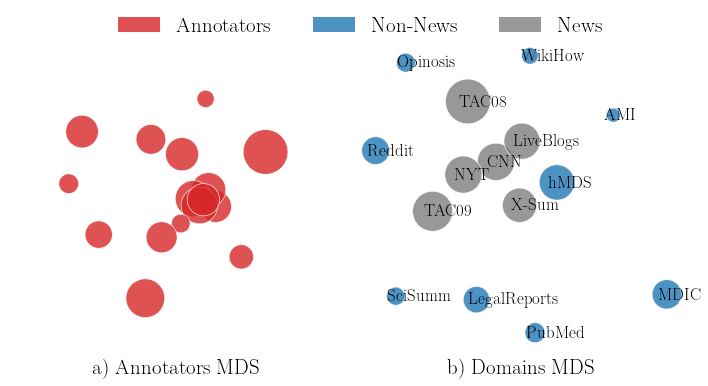

In [27]:
sns.set_context('paper')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
colors = ['tab:blue', 'tab:red', 'tab:grey']
sns.scatterplot(x='X', y='Y', size='generalizability', color=colors[1], ax=ax,
                        data=data_annotator_ann, sizes=(300,2000), palette=colors, legend=False, alpha=0.8)

# for ann, x, y in zip(annotators_K.keys(), data_annotator_ann['X'].to_list(), data_annotator_ann['Y'].to_list()):
#     ax.text(x-0.025, y-0.01, ann, color = 'white', fontsize=15)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('a) Annotators MDS', y=-0.1, fontsize=21)

# ax.grid()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xlim([-0.6, 0.6])
ax.set_ylim([-0.6, 0.6])
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
    
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False

ax = axes[1]

sns.scatterplot(x='X', y='Y', size='generalizability', hue='domains_dataset', ax=ax,
                        data=data_domain_MDS, sizes=(200,2000), palette=[colors[0], colors[2]], legend=False, alpha=0.8)

for dom, x, y in zip(domains_K.keys(), data_domain_MDS['X'].to_list(), data_domain_MDS['Y'].to_list()):
    if dom == 'TAC2008':
        dom = 'TAC08'
    elif dom == 'TAC2009':
        dom = 'TAC09'
    elif dom == 'CNN-DM':
        dom = 'CNN'
    ax.text(x-0.02, y-0.01, dom, color = 'black', fontsize=17)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('b) Domains MDS', y=-0.1, fontsize=21)

# ax.grid()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('')

for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
    
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
    
#g.get_legend().set_visible(False)
legend_elem = [
                mpatches.Patch(facecolor=colors[1], label='Annotators', alpha=0.8),
                mpatches.Patch(facecolor=colors[0], label='Non-News', alpha=0.8),
                mpatches.Patch(facecolor=colors[2], label='News', alpha=0.8)]
                   
fig.legend(handles=legend_elem, ncol=3, loc='upper center', frameon=False, fontsize=21,  bbox_to_anchor=(0.5, 1.08))
ax.set_ylabel('')
ax.set_xlabel('')
fig.tight_layout(pad=1.05)
fig.savefig("../outputs/mds.pdf", bbox_inches="tight")

In [15]:
TAC08_ann = [ann for ann in annotators_K.keys() if '8' in ann]
TAC09_ann = [ann for ann in annotators_K.keys() if '9' in ann]

x,y = [], []
nb_samples = 3
for nb_avg in range(1, int(len(annotators_K) /2.) , 3):
    for _ in range(nb_samples):
        ## Select from TAC-08 and evaluate on TAC-09
        selected_keys = random.sample(TAC08_ann, nb_avg)
        average_K = IT.avg([v['K'] for key, v in annotators_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(np.mean(utils.evaluate_K(dataset_09, average_K, 1, 1)))
        
        ## Select from TAC-09 and evaluate on TAC-08
        selected_keys = random.sample(TAC09_ann, nb_avg)
        average_K = IT.avg([v['K'] for key, v in annotators_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(np.mean(utils.evaluate_K(dataset_08, average_K, 1, 1)))
        
averaging_generalizability_ann_test = pd.DataFrame.from_dict({'# annotators averaged': x, 'Correlation with humans': y})

In [16]:
x,y = [], []
nb_samples = 3
for nb_avg in range(1, len(annotators_K), 3):
    for _ in range(nb_samples):
        selected_keys = random.sample(annotators_K.keys(), nb_avg)
        average_K = IT.avg([v['K'] for key, v in annotators_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(np.mean(utils.evaluate_K(dataset, average_K, 1, 1)))

full_avg = IT.avg([v['K'] for key, v in annotators_K.items()])
x.append(len(annotators_K))
y.append(np.mean(utils.evaluate_K(dataset, full_avg, 1, 1)))
#x.append(len(annotators_K))
#y.append(utils.evaluate_K(dataset, full_avg, 1, 1))
averaging_generalizability_ann = pd.DataFrame.from_dict({'# annotators averaged': x, 'Correlation with humans': y})

In [17]:
x,y = [], []
nb_samples = 6
for nb_avg in range(1, len(Non_News_subsets), 2):
    for _ in range(nb_samples):
        selected_keys = random.sample(Non_News_subsets.keys(), nb_avg)
        average_K = IT.avg([v['K'] for key, v in Non_News_subsets.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(np.mean(utils.evaluate_K(dataset, average_K, 1, 1)))

#full_avg = IT.avg([K for key, K in Non_News_subsets.items()])
#x.append(len(News_subsets))
#y.append(pipeline.evaluate_generic_K(dataset, full_avg, 1, 1))
averaging_generalizability_non_news = pd.DataFrame.from_dict({'# domains averaged': x, 'Correlation with humans': y})

x,y = [], []
nb_samples = 6
for nb_avg in range(1, len(domains_K), 3):
    for _ in range(nb_samples):
        selected_keys = random.sample(domains_K.keys(), nb_avg)
        average_K = IT.avg([v['K'] for key, v in domains_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(np.mean(utils.evaluate_K(dataset, average_K, 1, 1)))

#full_avg = IT.avg([K for key, K in Non_News_subsets.items()])
#x.append(len(News_subsets))
#y.append(pipeline.evaluate_generic_K(dataset, full_avg, 1, 1))
averaging_generalizability_dom = pd.DataFrame.from_dict({'# domains averaged': x, 'Correlation with humans': y})

In [18]:
with open('/Users/peyrardm/Documents/NLP/KLearn-code/outputs/optimal_K_1_.json', 'r') as f:
    optimal_K_1 =  json.loads(f.read())
    
# with open('../outputs/optimal_K_1_.json', 'r') as f:
#     optimal_K_1 =  json.loads(f.read())

def prepare_df(optimal):
    columns = {}
    for c in optimal[0].keys():
        columns[c] = [opt_k[c] for opt_k in optimal]
        
    return pd.DataFrame.from_dict(columns)

def build_stats_df(df):
    mean_values = df.mean(axis=0)
    se_values = df.sem(axis=0)
    stats_df = pd.concat([mean_values.to_frame('mean'), se_values.to_frame('se')], axis=1)
    stats_df['ci-95'] = 2.5 * stats_df['se']
    return stats_df.sort_values(by='mean', ascending=False)  

optimal_df = build_stats_df(prepare_df(optimal_K_1))

optimal_K = optimal_df['mean'].to_dict()

In [19]:
x,y = [], []
nb_samples = 3
for nb_avg in range(1, len(annotators_K), 3):
    for _ in range(nb_samples):
        selected_keys = random.sample(annotators_K.keys(), nb_avg)
        average_K = IT.avg([v['K'] for key, v in annotators_K.items() if key in selected_keys])
        
        
        x.append(nb_avg)
        y.append(IT.KL(average_K, optimal_K))

full_avg = IT.avg([v['K'] for key, v in annotators_K.items()])
x.append(len(annotators_K))
y.append(np.mean(utils.evaluate_K(dataset, full_avg, 1, 1)))
#x.append(len(annotators_K))
#y.append(utils.evaluate_K(dataset, full_avg, 1, 1))
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(np.array(y).reshape(-1, 1))

dist_opt_ann = pd.DataFrame.from_dict({'# annotators averaged': x, 'Distance to Optimal': y_scaled[:,0]})

x,y = [], []
nb_samples = 6
for nb_avg in range(1, len(domains_K), 3):
    for _ in range(nb_samples):
        selected_keys = random.sample(domains_K.keys(), nb_avg)
        average_K = IT.avg([v['K'] for key, v in domains_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(IT.KL(average_K, optimal_K))

#full_avg = IT.avg([K for key, K in Non_News_subsets.items()])
#x.append(len(News_subsets))
#y.append(pipeline.evaluate_generic_K(dataset, full_avg, 1, 1))

min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(np.array(y).reshape(-1, 1))

dist_opt_dom = pd.DataFrame.from_dict({'# domains averaged': x, 'Distance to Optimal': y_scaled[:,0]})

x,y = [], []
nb_samples = 6
for nb_avg in range(1, len(Non_News_subsets), 3):
    for _ in range(nb_samples):
        selected_keys = random.sample(Non_News_subsets.keys(), nb_avg)
        average_K = IT.avg([v['K'] for key, v in domains_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(IT.KL(average_K, optimal_K))

#full_avg = IT.avg([K for key, K in Non_News_subsets.items()])
#x.append(len(News_subsets))
#y.append(pipeline.evaluate_generic_K(dataset, full_avg, 1, 1))

min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(np.array(y).reshape(-1, 1))

dist_opt_dom_non_news = pd.DataFrame.from_dict({'# domains averaged': x, 'Distance to Optimal': y_scaled[:,0]})

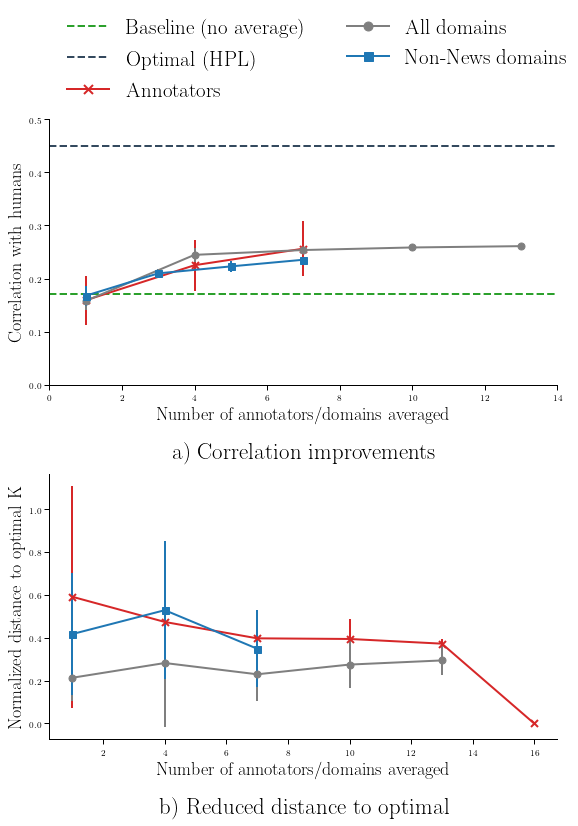

In [97]:
#sns.set_context('paper')
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharey=False, sharex=False)

ax = axes[0]

x = averaging_generalizability_ann_test[:-1].groupby('# annotators averaged').mean().index.to_list()
y = averaging_generalizability_ann_test[:-1].groupby('# annotators averaged').mean()['Correlation with humans'].to_list()
yerr = 1.96*averaging_generalizability_ann_test[:-1].groupby('# annotators averaged').sem()['Correlation with humans'].to_numpy()

ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
ax.set_ylim(0.0,0.50)

#ax.axhline(y=0.2, ls='--', linewidth=2, c='tab:green', label='Baseline')
# ax.axhline(y=0.45, ls='--', linewidth=2, c='#34495e', label='hPL')

ax.set_xlabel('Number of annotators averaged', fontsize=18)
ax.set_ylabel('Correlation with humans', fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



x = averaging_generalizability_dom.groupby('# domains averaged').mean().index.to_list()
y = averaging_generalizability_dom.groupby('# domains averaged').mean()['Correlation with humans'].to_list()
yerr = 1.96*averaging_generalizability_dom.groupby('# domains averaged').sem()['Correlation with humans'].to_numpy()

ax.errorbar(x,y,yerr,elinewidth=2, linewidth=2, fmt='-o', ms=7, color='tab:grey')

x = averaging_generalizability_non_news.groupby('# domains averaged').mean().index.to_list()
y = averaging_generalizability_non_news.groupby('# domains averaged').mean()['Correlation with humans'].to_list()
yerr = 1.96*averaging_generalizability_non_news.groupby('# domains averaged').sem()['Correlation with humans'].to_numpy()

ax.errorbar(x,y,yerr,elinewidth=2, linewidth=2, fmt='-s', ms=7, color='tab:blue')

ax.set_ylim(0.0,0.50)
ax.set_xlim(0,14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(y=0.17, ls='--', linewidth=2, c='tab:green', label='Baseline')
ax.axhline(y=0.45, ls='--', linewidth=2, c="#34495e", label='hPL')

ax.set_xlabel('Number of annotators/domains averaged', fontsize=18)
ax.set_title('a) Correlation improvements', fontsize=23, y=-0.3)
#ax.set_ylabel('Correlation with humans', fontsize=13)




ax = axes[1]



x = dist_opt_ann.groupby('# annotators averaged').mean().index.to_list()
y = dist_opt_ann.groupby('# annotators averaged').mean()['Distance to Optimal'].to_list()
yerr = 2*dist_opt_ann.groupby('# annotators averaged').sem()['Distance to Optimal'].to_numpy()

ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')


ax.set_xlabel('Number of annotators/domains averaged', fontsize=18)
ax.set_ylabel('Normalized distance to optimal K', fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


x = dist_opt_dom.groupby('# domains averaged').mean().index.to_list()
y = dist_opt_dom.groupby('# domains averaged').mean()['Distance to Optimal'].to_list()
yerr = 2*dist_opt_dom.groupby('# domains averaged').sem()['Distance to Optimal'].to_numpy()

ax.errorbar(x,y,yerr,elinewidth=2, linewidth=2, fmt='-o', ms=7, color='tab:grey')

x = dist_opt_dom_non_news.groupby('# domains averaged').mean().index.to_list()
y = dist_opt_dom_non_news.groupby('# domains averaged').mean()['Distance to Optimal'].to_list()
yerr = 2*dist_opt_dom_non_news.groupby('# domains averaged').sem()['Distance to Optimal'].to_numpy()

ax.errorbar(x,y,yerr,elinewidth=2, linewidth=2, fmt='-s', ms=7, color='tab:blue')
ax.set_title('b) Reduced distance to optimal', fontsize=23, y=-0.3)


#g.legend().set_visible(False)
legend_elem = [Line2D([0], [0], linestyle='--', linewidth=2, c='tab:green', label='Baseline (no average)'),
               Line2D([0], [0], linestyle='--', linewidth=2, c="#34495e", label='Optimal (HPL)'),
               Line2D([0], [0], marker='x', linewidth=2, ms=9, mew=2, c='tab:red', label='Annotators'),
               Line2D([0], [0], marker='o', linewidth=2, ms=9, c='tab:grey', label='All domains'),
              Line2D([0], [0], marker='s', linewidth=2, ms=9, c='tab:blue', label='Non-News domains')]

fig.legend(handles=legend_elem, ncol=2, loc='upper center', frameon=False, fontsize=21,  bbox_to_anchor=(0.55, 1.15))
#fig.legend(handles=legend_elem, fontsize=13)
fig.tight_layout(pad=1.1)
fig.savefig("../outputs/averaging_double.pdf", bbox_inches="tight")

# Annotator Analysis

### Averaging improves performances

In [52]:
TAC08_ann = [ann for ann in annotators_K.keys() if '8' in ann]
TAC09_ann = [ann for ann in annotators_K.keys() if '9' in ann]

x,y = [], []
nb_samples = 3
for nb_avg in range(1, int(len(annotators_K) /2.) , 3):
    for _ in range(nb_samples):
        ## Select from TAC-08 and evaluate on TAC-09
        selected_keys = random.sample(TAC08_ann, nb_avg)
        average_K = IT.avg([v['K'] for key, v in annotators_K.items() if key in selected_keys])
        
        x.append(nb_avg)
        y.append(np.mean(utils.evaluate_K(dataset_09, average_K, 1, 1)))
        
        ## Select from TAC-09 and evaluate on TAC-08
        #selected_keys = random.sample(TAC09_ann, nb_avg)
        #average_K = IT.avg([v['K'] for key, v in annotators_K.items() if key in selected_keys])
        
        #x.append(nb_avg)
        #y.append(np.mean(utils.evaluate_K(dataset_08, average_K, 1, 1)))



#full_avg = IT.avg([v['K'] for key, v in annotators_K.items()])
#x.append(len(annotators_K))
#y.append(np.mean(utils.evaluate_K(dataset, full_avg, 1, 1)))
#x.append(len(annotators_K))
#y.append(utils.evaluate_K(dataset, full_avg, 1, 1))
averaging_generalizability_ann_test = pd.DataFrame.from_dict({'# annotators averaged': x, 'Correlation with humans': y})

# Plots For Paper

In [9]:
def build_corr_geom(annotators_K):
    keys = annotators_K.keys()
    idx = range(len(keys))
    keys_idx = dict(zip(keys, idx))
    
    sizes = []
    annots = list(annotators_K.items())
    corr = np.ones((len(keys), len(keys)))
    for a_i, v_i in annots:
        #sizes.append(np.mean(utils.evaluate_K(dataset, v_i['K'], 1., 1.)))
        for a_j, v_j in annots:
            x_i = keys_idx[a_i]
            x_j = keys_idx[a_j]
            corr[x_i][x_j] = IT.JS(v_i, v_j)
    return corr, keys_idx, np.array(sizes)

In [16]:
with open('../../KLearn-code/outputs/optimal_K_1_.json', 'r') as f:
    optimal_K_1 =  json.loads(f.read())
    
def prepare_df(optimal):
    columns = {}
    for c in optimal[0].keys():
        columns[c] = [opt_k[c] for opt_k in optimal]
        
    return pd.DataFrame.from_dict(columns)

def build_stats_df(df):
    mean_values = df.mean(axis=0)
    se_values = df.sem(axis=0)
    stats_df = pd.concat([mean_values.to_frame('mean'), se_values.to_frame('se')], axis=1)
    stats_df['ci-95'] = 2.5 * stats_df['se']
    return stats_df.sort_values(by='mean', ascending=False)  

optimal_df = build_stats_df(prepare_df(optimal_K_1))
optimal_K = optimal_df['mean'].to_dict()

In [19]:
a = np.mean(utils.evaluate_K(dataset_08, optimal_K, 1., 1.))
b = np.mean(utils.evaluate_K(dataset_09, optimal_K, 1., 1.))
print((a + b)/2)
a = np.mean(utils.evaluate_MR(dataset_08, optimal_K, 1., 1.))
b = np.mean(utils.evaluate_MR(dataset_09, optimal_K, 1., 1.))
print((a + b)/2)

0.4566147878345657
14.493371212121213


In [51]:
with open('assessor_topics.json', 'r') as f:
    assessors = json.loads(f.read())

In [86]:
documents_to_keep = [k for k,v in assessors.items() if v == 'E9'] 

In [87]:
print(documents_to_keep)

['D0910', 'D0925', 'D0926', 'D0927', 'D0928', 'D0929', 'D0939']


In [88]:
tac2009 = utils.load_data(os.path.join('/Users/peyrardm/Documents/NLP/KLearn-preprocess/data_converted', 'TAC2009_1.pkl'))

In [89]:
text_rep = {}
for k,v in tac2009.items():
    if k in documents_to_keep:
        if k == 'D0925':
            continue
        text_rep['doc-{}'.format(k)] = v.doc_freq
        kept = sorted(v.annotations, key=lambda t: t['pyr_score'], reverse=True)[:4]
        for i, summary in enumerate(kept):
            text_rep['summary-{}-{}'.format(k, i)] = summary['freq']

In [90]:
text_rep['K'] = optimal_K

In [91]:
corr, keys_idx, _ = build_corr_geom(text_rep)

In [92]:
def map_to_type(name):
    if 'K' in name:
        return 'K'
    if 'summary' in name:
        return 'summary'
    if 'doc' in name:
        return 'name'

In [93]:
X = corr 
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(X)
    
rep = [f for f, _ in sorted(keys_idx.items(), key=lambda t: t[1])]
rep_types = [map_to_type(f) for f in rep]
x = X_transformed[:,0]
y = X_transformed[:,1]

data = pd.DataFrame.from_dict({'X': x, 'Y': y, 'rep':rep, 'rep_types': rep_types})

In [94]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


data_with_jitter = data.copy()
data_with_jitter['X'] = rand_jitter(data_with_jitter['X'])
data_with_jitter['Y'] = rand_jitter(data_with_jitter['Y'])

In [95]:
# Remove jitter from K
data_with_jitter.loc[data_with_jitter['rep'] == 'K', 'X'] = 0
data_with_jitter.loc[data_with_jitter['rep'] == 'K', 'Y'] = 0

Text(0.5, 41.0, '')

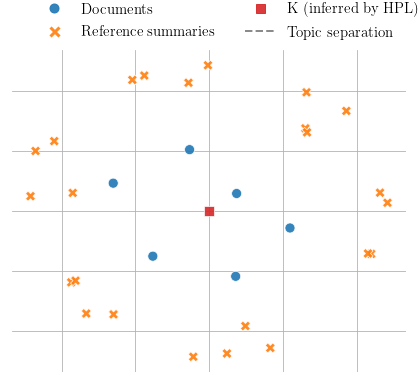

In [96]:
import matplotlib.lines as mlines

sns.set_context('paper')
fig, ax = plt.subplots(1, 1, figsize=(6, 5))


#plt.figure(figsize=(6,5))
colors = ['tab:blue', 'tab:orange', 'tab:red']
sns.scatterplot(x='X', y='Y', ax=ax, hue='rep_types', style="rep_types", 
                        data=data_with_jitter, s=100, palette=colors, alpha=0.9, legend=False, zorder=120)

#for ann, x, y in zip(annotators_K.keys(), x, y):
#    ax.text(x-0.018, y-0.01, ann, color = 'white', fontsize=11)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid()
#ax.set_xticklabels([])
#ax.set_yticklabels([])

for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
    
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
#ax.get_legend().set_visible(False)

# l = mlines.Line2D([0,0.1], [0, 0.5], linestyle='--', linewidth=2, color='tab:grey', zorder=10, alpha=0.8)
# ax.add_line(l)
# l = mlines.Line2D([0,0.5], [0, 0.1], linestyle='--', linewidth=2, color='tab:grey', zorder=10, alpha=0.8)
# ax.add_line(l)
# l = mlines.Line2D([0,0.4], [0, -0.4], linestyle='--', linewidth=2, color='tab:grey', zorder=10, alpha=0.8)
# ax.add_line(l)
# l = mlines.Line2D([0,-0.1], [0, -0.45], linestyle='--', linewidth=2, color='tab:grey', zorder=10, alpha=0.8)
# ax.add_line(l)
# l = mlines.Line2D([0,-0.5], [0, -0.1], linestyle='--', linewidth=2, color='tab:grey', zorder=10, alpha=0.8)
# ax.add_line(l)
# l = mlines.Line2D([0,-0.4], [0, 0.4], linestyle='--', linewidth=2, color='tab:grey', zorder=10, alpha=0.8)
# ax.add_line(l)
    
legend_elem = [
#                 mpatches.Patch(facecolor=colors[0], label='Documents'),
#                mpatches.Patch(facecolor=colors[1], label='Reference summaries'),
#                mpatches.Patch(facecolor=colors[2], label='K (inferred by hPL)'),
               Line2D([0], [0], marker='o', linestyle='', ms=9, c=colors[0], alpha=0.9, label='Documents'),
               Line2D([0], [0], marker='x', linestyle='', ms=9, mew=3, c=colors[1], alpha=0.9, label='Reference summaries'),
               Line2D([0], [0], marker='s', linestyle='', ms=9, c=colors[2], alpha=0.9, label='K (inferred by HPL)'),
               Line2D([0], [0], linestyle='--', linewidth=2, c='tab:grey', alpha=0.9, label='Topic separation')
              ]

fig.legend(handles=legend_elem, ncol=2, loc='upper center', fontsize=15, bbox_to_anchor=(0.53, 1.1), frameon=False)
fig.tight_layout(pad=1)
ax.set_ylabel('')
ax.set_xlabel('')
# fig.savefig("../outputs/geometry.pdf", bbox_inches="tight")